In [ ]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
df = pd.read_csv('/content/YT-titles-transcripts-clean(1).csv')

In [ ]:
df.head()

,vid_id,title,transcript,category_1,category_2,task_id,punctuated,transcript_num_chars,default_language,default_audio_language
0,_jo1UnkkD-A,The Best Game Controller,"- Hey, guys, this is Austin. So there are a to...",Food and Entertaining,Recipes,Make Game Controller Cookies,True,10350,en,en
1,30mzPmm7gvg,CANDY BAR CONTROLLERS - NERDY NUMMIES,"Hey guys, it’s Ro! Welcome to another Nerdy Nu...",Food and Entertaining,Recipes,Make Game Controller Cookies,True,4181,en,en
2,evQsOFQju08,Is Your Red The Same as My Red?,"Hey, Vsauce. Michael here. This appears blue. ...",Hobbies and Crafts,Crafts,Make Deep Yellow Colored Water from Saffron,True,7190,en,en
3,-ToIM0aREY8,Make Bright Christmas Ornaments in a Minute,In a previous video we learned how to make the...,Hobbies and Crafts,Crafts,Make a Metallic and Paper Christmas Star,True,1424,en,en
4,GsJpF0edPxw,10 Rubbing Alcohol Life Hacks You Need To Know,- Do you instinctively reach for the rubbing a...,Hobbies and Crafts,Crafts,Clean with Rubbing Alcohol,True,9102,en,en


In [ ]:


category2_mapping = {
    # Food & Cooking
    'Recipes': 'Food & Cooking',
    'Drinks': 'Food & Cooking',
    'Care and Use of Cooking Equipment': 'Food & Cooking',
    'Food Preparation': 'Food & Cooking',
    'Holiday Cooking': 'Food & Cooking',
    'Barbecue': 'Food & Cooking',
    'Breakfast': 'Food & Cooking',
    'Cooking for Children': 'Food & Cooking',
    'Diet & Lifestyle': 'Food & Cooking',
    'Appreciation of Food': 'Food & Cooking',

    # Arts & Crafts
    'Crafts': 'Arts & Crafts',
    'Painting': 'Arts & Crafts',
    'Sculpting': 'Arts & Crafts',
    'Woodworking': 'Arts & Crafts',
    'Model Making': 'Arts & Crafts',
    'Digital Technology Art and Craft Projects': 'Arts & Crafts',

    # Pets & Animals
    'Cats': 'Pets & Animals',
    'Dogs': 'Pets & Animals',
    'Birds': 'Pets & Animals',
    'Fish': 'Pets & Animals',
    'Horses': 'Pets & Animals',
    'Reptiles': 'Pets & Animals',
    'Small and Furry': 'Pets & Animals',
    'Rabbits': 'Pets & Animals',
    'Wildlife': 'Pets & Animals',
    'General Pet Health': 'Pets & Animals',
    'Animal Rescue': 'Pets & Animals',
    'Animal Welfare Activism': 'Pets & Animals',

    # Health & Wellness
    'Conditions and Treatments': 'Health & Wellness',
    'Medication and Medical Equipment': 'Health & Wellness',
    'Alternative Health': 'Health & Wellness',
    'Emotional Health': 'Health & Wellness',
    'Personal Hygiene': 'Health & Wellness',
    'Grooming': 'Health & Wellness',
    'Women’s Health': 'Health & Wellness',
    "Men's Health": 'Health & Wellness',
    'Health Hygiene': 'Health & Wellness',
    'Health Care and Medical Information': 'Health & Wellness',

    # Home & Lifestyle
    'Home Improvements and Repairs': 'Home & Lifestyle',
    'Housekeeping': 'Home & Lifestyle',
    'Landscaping and Outdoor Building': 'Home & Lifestyle',
    'Home Decorating': 'Home & Lifestyle',
    'Gardening': 'Home & Lifestyle',
    'Sustainable Living': 'Home & Lifestyle',
    'Moving House and Packing': 'Home & Lifestyle',

    # Sports & Fitness
    'Team Sports': 'Sports & Fitness',
    'Individual Sports': 'Sports & Fitness',
    'Personal Fitness': 'Sports & Fitness',
    'Vehicle Sports': 'Sports & Fitness',
    'Swimming Pools Spas and Hot Tubs': 'Sports & Fitness',

    # Technology
    'Phones and Gadgets': 'Technology',
    'Software': 'Technology',
    'Networking': 'Technology',
    'Hardware': 'Technology',
    'Laptops': 'Technology',
    'Optical Devices': 'Technology',
    'TV and Home Audio': 'Technology',
    'Digital Technology Art and Craft Projects': 'Technology',
    'Amateur Radio': 'Technology',

    # Vehicles
    'Cars': 'Vehicles',
    'Motorcycles': 'Vehicles',
    'Bicycles': 'Vehicles',
    'Trucks': 'Vehicles',
    'Scooters': 'Vehicles',
    'Trailers': 'Vehicles',
    'Boats': 'Vehicles',
    'Aviation': 'Vehicles',
    'Off Road Vehicles': 'Vehicles',
    'Recreational Vehicles': 'Vehicles',

    # Holidays & Traditions
    'Halloween': 'Holidays & Traditions',
    'Easter': 'Holidays & Traditions',
    'Christmas': 'Holidays & Traditions',
    "Saint Patrick's Day": 'Holidays & Traditions',
    'Valentines Day': 'Holidays & Traditions',
    'Thanksgiving': 'Holidays & Traditions',
    "Mother's Day": 'Holidays & Traditions',

    # Other
    'Books': 'Other',
    'Writing': 'Other',
    'Religion': 'Other',
    'Occupations': 'Other',
    'Performing Arts': 'Other',
    'Movies': 'Other',
    'Music': 'Other',
    'Social Activism': 'Other',
    'Disaster Preparedness': 'Other',
    'Photography': 'Other',
    'Flags': 'Other',
    'Cosplay and Role Playing': 'Other',
    'Boredom Busters': 'Other',
    'Parenting': 'Other',
    'Travel Tips': 'Other',
    'Business': 'Other',
    'Dining Etiquette': 'Other',
    'Dining Out': 'Other',
    'Gift Giving': 'Other',
    'Fashion': 'Other',
    'Carnivals Circuses and Theme Parks': 'Other',
    'Presentations': 'Other',
    'Speaking': 'Other',
    'Emotional Health': 'Other',
    'Bugs': 'Other',
    'Crustaceans': 'Other',
    'Amphibian': 'Other',
    'Snails and Slugs': 'Other',
    'General Pet Accessories': 'Other',
    'Recreational Drug Use': 'Other',
    'Injury and Accidents': 'Other',
    'Tricks and Pranks': 'Other',
    'Parties': 'Other',
    'Costumes': 'Other',
    'Flags': 'Other'
}


In [ ]:
df['reduced_category'] = df['category_2'].map(category2_mapping).fillna('Other')


In [ ]:
df_food = df[df['reduced_category'] == 'Food & Cooking']
df_other = df[df['reduced_category'] != 'Food & Cooking']
df_food_downsampled = df_food.sample(n=3000, random_state=42)
df_balanced = pd.concat([df_food_downsampled, df_other])


In [ ]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

food_cooking_subset = df[df['reduced_category'] == 'Food & Cooking'].sample(n=3000, random_state=42)
other_categories = df[df['reduced_category'] != 'Food & Cooking']
df_reduced = pd.concat([food_cooking_subset, other_categories], ignore_index=True)


oversampling_strategy = {
    'Food & Cooking': 3247,
    'Arts & Crafts': 3247,
    'Home & Lifestyle': 3247,
    'Vehicles': 1500,
    'Pets & Animals': 1500,
    'Holidays & Traditions': 1000,
    'Technology': 1000,

}


oversampler = RandomOverSampler(sampling_strategy=oversampling_strategy, random_state=42)


X_balanced, y_balanced = oversampler.fit_resample(
    df_reduced[['title', 'transcript']],
    df_reduced['reduced_category']
)


df_balanced = pd.DataFrame({
    'title': X_balanced['title'],
    'transcript': X_balanced['transcript'],
    'reduced_category': y_balanced
})

# Step 6: Verify the class distribution
print("Original Distribution:")
print(df['reduced_category'].value_counts())
print("\nReduced Distribution (after undersampling 'Food & Cooking'):")
print(df_reduced['reduced_category'].value_counts())
print("\nBalanced Distribution (after oversampling):")
print(df_balanced['reduced_category'].value_counts())


df_balanced.to_csv("balanced_dataset.csv", index=False)


Original Distribution:
reduced_category
Food & Cooking           6659
Other                    3290
Arts & Crafts            3132
Home & Lifestyle         3092
Vehicles                  608
Pets & Animals            526
Holidays & Traditions     369
Health & Wellness         198
Sports & Fitness          160
Technology                100
Name: count, dtype: int64

Reduced Distribution (after undersampling 'Food & Cooking'):
reduced_category
Other                    3290
Arts & Crafts            3132
Home & Lifestyle         3092
Food & Cooking           3000
Vehicles                  608
Pets & Animals            526
Holidays & Traditions     369
Health & Wellness         198
Sports & Fitness          160
Technology                100
Name: count, dtype: int64

Balanced Distribution (after oversampling):
reduced_category
Other                    3290
Food & Cooking           3247
Arts & Crafts            3247
Home & Lifestyle         3247
Vehicles                 1500
Pets & Animals   

In [ ]:

df_balanced['text'] = df_balanced['title'] + " " + df_balanced['transcript']


df_balanced = df_balanced.rename(columns={'reduced_category': 'category'})

df_balanced = df_balanced.drop(columns=['title', 'transcript'])



df_balanced.head()


In [ ]:
df_org = df_balanced.copy()

In [ ]:

exclude_categories = [
    'Vehicles', 'Pets & Animals', 'Technology',
    'Holidays & Traditions', 'Health & Wellness',
    'Sports & Fitness'
]


df_filtered = df_org[~df_org['category'].isin(exclude_categories)]


print(df_filtered.head())


df_filtered.to_csv("filtered_data.csv", index=False)


         category                                               text
0  Food & Cooking  The Best Red Wines For Beginners (Series): #3 ...
1  Food & Cooking  MIRROR GLAZE CAKE - FAIL included - buttercrea...
2  Food & Cooking  Pumpkin Raisin Bread | A Sweet Pea Chef ♪ [mus...
3  Food & Cooking  GUESS THAT OREO CHALLENGE! (Kids Vs. Food) ♪ (...
4  Food & Cooking  Whole Wheat Bread Recipe - Homemade Whole Whea...


In [ ]:
df_org = df_filtered.copy()

In [ ]:
labels = df_org['category'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['Food & Cooking', 'Arts & Crafts', 'Home & Lifestyle', 'Other']

In [ ]:
df_org.head()

,category,text
0,Food & Cooking,The Best Red Wines For Beginners (Series): #3 ...
1,Food & Cooking,MIRROR GLAZE CAKE - FAIL included - buttercrea...
2,Food & Cooking,Pumpkin Raisin Bread | A Sweet Pea Chef ♪ [mus...
3,Food & Cooking,GUESS THAT OREO CHALLENGE! (Kids Vs. Food) ♪ (...
4,Food & Cooking,Whole Wheat Bread Recipe - Homemade Whole Whea...


In [ ]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [ ]:
label2id

{'Food & Cooking': 0, 'Arts & Crafts': 1, 'Home & Lifestyle': 2, 'Other': 3}

In [ ]:
id2label

{0: 'Food & Cooking', 1: 'Arts & Crafts', 2: 'Home & Lifestyle', 3: 'Other'}

In [ ]:
df_org['labels'] = pd.factorize(df_org.category)[0]


In [ ]:
df_org = df_org.drop('labels_num', axis=1, errors='ignore')
df_org.sample(10)

,category,text,labels
14103,Other,"Cardi B Carpool Karaoke OH, THANK YOU SO MUCH ...",3
7725,Arts & Crafts,HOW to CROCHET a BEGINNER EASY FLOWER - DIY Ro...,1
3280,Arts & Crafts,Mummy Dogs ~ Tasty Halloween Dinner Idea ~ Cre...,1
14122,Home & Lifestyle,"Pepper Seedlings, One Pot Herb Garden, and For...",2
14611,Food & Cooking,The Charleston Benne Wafer *Machine Sounds* &l...,0
4821,Arts & Crafts,How Do Glaciers Move? Here’s something we all ...,1
5161,Arts & Crafts,DIY School Supplies! 10 Weird DIY Crafts for B...,1
6630,Arts & Crafts,Glitter and Tire Sealant - Does it work? I've ...,1
3508,Other,"Will Toy Caps Ignite Gasoline? Hey guys, today...",3
14700,Food & Cooking,Healthy Green Smoothie with Spinach and Fruit ...,0


<Axes: ylabel='count'>

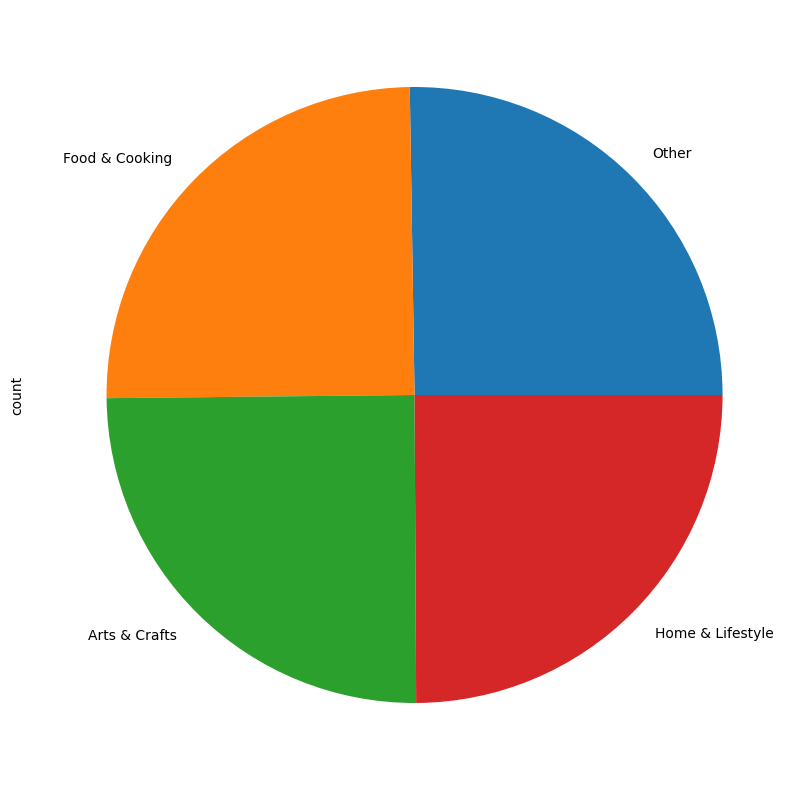

In [ ]:
df_org.category.value_counts().plot(kind='pie', figsize=(10,10))

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
model = BertForSequenceClassification.from_pretrained( "bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
SIZE= df_org.shape[0]

train_texts= list(df_org.text[:SIZE//2])

val_texts=   list(df_org.text[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.text[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

In [ ]:
len(train_texts)

6515

In [ ]:
len(train_texts), len(val_texts), len(test_texts)

(6515, 3258, 3258)

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

# Training


In [ ]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [ ]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./TTC4900Model',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.248200,1.844402,0.074893,0.106087,0.121032,0.094427
100,0.927000,1.237280,0.475752,0.375812,0.434117,0.379456
150,0.908000,1.490864,0.363720,0.334513,0.450434,0.281290
200,0.845300,1.510398,0.450890,0.365643,0.447968,0.360406
250,0.800700,1.490033,0.434622,0.376350,0.461613,0.345653
300,0.845300,1.570412,0.428177,0.346381,0.451412,0.353094
350,0.775700,1.421043,0.492940,0.402579,0.451168,0.384722
400,0.825400,1.571661,0.403622,0.342998,0.454564,0.339889
450,0.692700,1.337221,0.515347,0.418662,0.462789,0.396606
500,0.685600,1.477929,0.465009,0.383666,0.464607,0.371455


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classifi

TrainOutput(global_step=1224, training_loss=0.6626870265973159, metrics={'train_runtime': 1119.9739, 'train_samples_per_second': 17.451, 'train_steps_per_second': 1.093, 'total_flos': 5142597921976320.0, 'train_loss': 0.6626870265973159, 'epoch': 3.0})

In [ ]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.601220,0.789409,0.726279,0.748051,0.714415
val,1.477929,0.465009,0.383666,0.464607,0.371455
test,1.403676,0.508287,0.502744,0.535356,0.605340


In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [ ]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label
    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

## Output

In [ ]:
# Test with a an example text in Turkish
text = "Incredible Egg Cooking School - Scrambled"
# "Machine Learning itself is moving towards more and more automated"
predict(text)

(tensor([[0.9352, 0.0315, 0.0042, 0.0291]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(0, device='cuda:0'),
 'Food & Cooking')

In [ ]:
# Test with a an example text in Turkish
text = "making a drawing with crayons"
# "Machine Learning itself is moving towards more and more automated"
predict(text)

(tensor([[0.0278, 0.8452, 0.0304, 0.0965]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(1, device='cuda:0'),
 'Arts & Crafts')

In [ ]:
# Test with a an example text in Turkish
text = "making a drawing with water colurs"
# "Machine Learning itself is moving towards more and more automated"
predict(text)

(tensor([[0.0486, 0.6588, 0.0504, 0.2421]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(1, device='cuda:0'),
 'Arts & Crafts')

# Saving model



In [ ]:
model_path = "classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('classification-model/tokenizer_config.json',
 'classification-model/special_tokens_map.json',
 'classification-model/vocab.txt',
 'classification-model/added_tokens.json',
 'classification-model/tokenizer.json')

In [ ]:
import shutil

# Create a zip file of the saved model folder
shutil.make_archive(model_path, 'zip', model_path)

# The model is now zipped. To download it, you can create a download link:
from google.colab import files
files.download(f'{model_path}.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your Google Drive folder
drive_path = "/content/drive/My Drive/classification-model"  # Change to the desired folder

# Save the model and tokenizer to Google Drive
trainer.save_model(drive_path)
tokenizer.save_pretrained(drive_path)


Mounted at /content/drive


('/content/drive/My Drive/classification-model/tokenizer_config.json',
 '/content/drive/My Drive/classification-model/special_tokens_map.json',
 '/content/drive/My Drive/classification-model/vocab.txt',
 '/content/drive/My Drive/classification-model/added_tokens.json',
 '/content/drive/My Drive/classification-model/tokenizer.json')

In [ ]:
model_path = '/content/classification-model'

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
nlp("making a drawing with water colurs")

[{'label': 'Arts & Crafts', 'score': 0.6589387059211731}]

In [ ]:
nlp("How to cook mashed potato in 30 minutes")

[{'label': 'Food & Cooking', 'score': 0.9309812188148499}]